In [43]:
import numpy as np
import  pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle
warnings.filterwarnings('ignore')

plt.style.use("seaborn-whitegrid")
plt.rcParams["font.size"] = 14

In [45]:
# Use for all the same features
data = pd.read_csv("Cleaned_2014.csv")
data2 = pd.read_csv("Cleaned_2015.csv")
data3 = pd.read_csv("Cleaned_2016.csv")
data4 = pd.read_csv("Cleaned_2017.csv")
data5= pd.read_csv("Cleaned_2018.csv")

data_price = data.loc[:, ["2015 PRICE VAR [%]"]]
data_price2 = data2.loc[:, ["2016 PRICE VAR [%]"]]
data_price3 = data3.loc[:, ["2017 PRICE VAR [%]"]]
data_price4 = data4.loc[:, ["2018 PRICE VAR [%]"]]
data_price5 = data5.loc[:, ["2019 PRICE VAR [%]"]]

a = []
for i in list(data):
  if i in list(data2) and i in list(data3) and i in list(data4) and i in list(data5):
      a.append(i)

data = data[a[1:]].join(data_price).rename(columns={"2015 PRICE VAR [%]":"PRICE VAR [%]"})
data2 = data2[a[1:]].join(data_price2).rename(columns={"2016 PRICE VAR [%]":"PRICE VAR [%]"})
data3 = data3[a[1:]].join(data_price3).rename(columns={"2017 PRICE VAR [%]":"PRICE VAR [%]"})
data4 = data4[a[1:]].join(data_price4).rename(columns={"2018 PRICE VAR [%]":"PRICE VAR [%]"})
data5 = data5[a[1:]].join(data_price5).rename(columns={"2019 PRICE VAR [%]":"PRICE VAR [%]"})

df_list = [data,data2,data3,data4,data5]
#Concatenate all df to one to use it for the ML_tool
df = pd.concat([data,data2,data3,data4,data5])

df.to_csv("df.csv")
#Make a pair plot to show hot they are connected, It takes big amounts of computational power to do it for all but some can be calculated
#for i in df_list:
    #sns.pairplot(i.iloc[:,30:], hue="Class")

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, neighbors
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA

data = pd.read_csv("df.csv")

x_data = data.drop(["Class", "PRICE VAR [%]"],axis=1)
y_data = data["Class"]
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(x_data)
data = pd.DataFrame(X_data_minmax,columns=list(x_data))

#For predicting future sell buy hold. It makes more sense to not shuffle the values. Since the stock price changes over time and we want to predict the future values
X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.2, random_state = 0)
#TODO should we add shuffle to false -> affecting the prediction of the data

MinMaxScaler.fit(X_train)
X_train = MinMaxScaler.fit_transform(X_train)
X_test = MinMaxScaler.fit_transform(X_test)
#We could choose with neighbors.KNeighborsClassifier(n_neighbors=#) the amount of neighbors but it decides to choose the best one by itself, if we try to add a number it is always worse than the default
#knn_clf=KNeighborsClassifier() #by using KNN we get a score of 0.65, but using SVC we have 0.85 a huge improvement
print("Number of train elements: " + str(len(X_train)))
print("Number of test elements: " + str(len(X_test)))

Number of train elements: 17571
Number of test elements: 4393


In [42]:
#See which classes are the most important for the RandomForest
forest = RandomForestClassifier(random_state=1)
forest.fit(X_train, y_train)
feat_labels = data.columns[:-1]
importance = forest.feature_importances_
feat_imp = np.sort(importance)[::-1]
sum_feat_imp = np.cumsum(feat_imp)
plt.figure(figsize=(12,5))
plt.bar(range(len(importance)-1), importance[1:], align="center")
plt.xticks(range(len(importance)-1), list(data)[1:], rotation=90)
plt.xlabel("Features")
plt.ylabel("Relative Feature Importance")

KeyboardInterrupt: 

In [ ]:
def plot_matrix(model, model_name):
    ypred = model.predict(X_test)
    result = confusion_matrix(y_test, ypred)
    print("Confusion Matrix {}:".format(model_name))
    print(result)
    result1 = classification_report(y_test, ypred)
    print("Classification Report:",)
    print (result1)
    result2 = accuracy_score(y_test,ypred)
    print("Accuracy {}: ".format(model_name),result2)
    disp = ConfusionMatrixDisplay(confusion_matrix=result,
                                      display_labels=model.classes_)
    disp.plot(cmap="YlGn")
    disp.ax_.set_title("{} Score: ".format(model_name)+str(round(result2, 4)))

Confusion Matrix QDA:
[[2369    0    0]
 [ 262    0    0]
 [1762    0    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2369
           1       0.00      0.00      0.00       262
           2       0.00      0.00      0.00      1762

    accuracy                           0.54      4393
   macro avg       0.18      0.33      0.23      4393
weighted avg       0.29      0.54      0.38      4393

Accuracy: QDA 0.5392670157068062
Confusion Matrix KNN:
[[1469   19  881]
 [ 178    1   83]
 [1030   15  717]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58      2369
           1       0.03      0.00      0.01       262
           2       0.43      0.41      0.42      1762

    accuracy                           0.50      4393
   macro avg       0.33      0.34      0.34      4393
weighted avg       0.47      0.50      0.48      4393

Accur

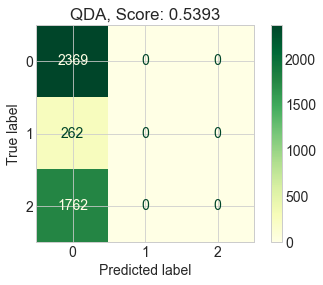

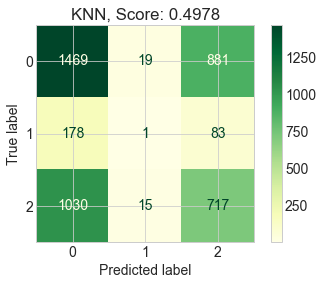

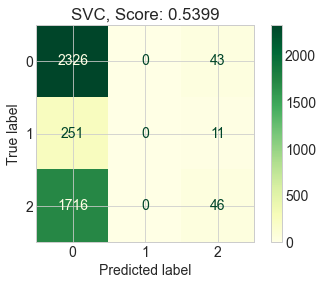

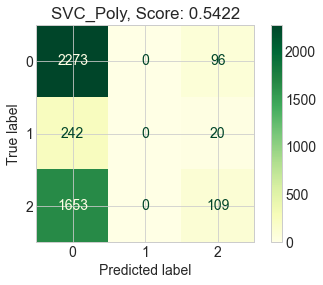

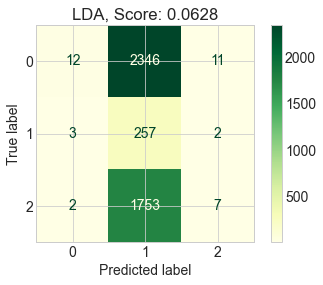

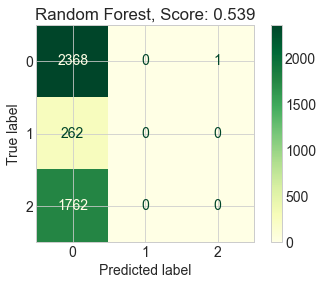

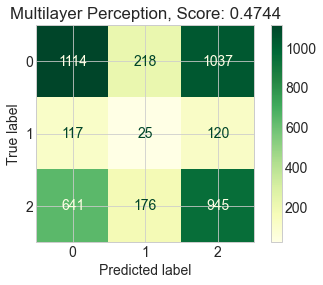

In [47]:
from sklearn.feature_selection import SelectFromModel
#import xgboost
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV
#xgb = xgboost.XGBClassifier(max_depth=10, n_estimators=1000)
#m = RFECV(RandomForestClassifier(), scoring="accuracy")
mlp = MLPClassifier(random_state=0)
randomForest = RandomForestClassifier(random_state=0, class_weight="balanced")
algonames = ["QDA", "KNN", "SVC", "SVC_Poly", "LDA", "Random Forest", "Multilayer Perception"]
counter = 0
knn = KNeighborsClassifier()
svc = SVC(random_state=0)
svc_poly =SVC(kernel="poly", random_state=0)
lda = LDA(solver="lsqr")
qda = QDA()
options= [qda, knn, svc, svc_poly, lda, randomForest, mlp]
for i in options:
    i.fit(X_train,y_train)
    ypred=i.predict(X_test)
    result = confusion_matrix(y_test, ypred)
    print("Confusion Matrix {}:".format(algonames[counter]))
    print(result)
    result1 = classification_report(y_test, ypred)
    print("Classification Report:",)
    print (result1)
    result2 = accuracy_score(y_test,ypred)
    print("Accuracy: {}".format(algonames[counter]),result2)
    disp = ConfusionMatrixDisplay(confusion_matrix=result,
                                  display_labels=i.classes_)
    disp.plot(cmap="YlGn")
    disp.ax_.set_title(algonames[counter]+", Score: "+str(round(result2, 4)))
    counter+=1

    #plot_confusion_matrix(i, X_test, y_test, cmap="YlGn", normalize="pred")

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/

from sklearn.feature_selection import SelectFromModel

pipe = Pipeline([("feature_selection", SelectFromModel(RandomForestClassifier(), threshold="median")),
                 ("scaler", StandardScaler()),
                 ("classification", RandomForestClassifier())])
pipe.fit(X_train, y_train).score(X_test, y_test)

pca = PCA(n_components=20)
pca.fit(X_test)
print(pca.explained_variance_ratio_)

[0.21252105 0.16559743 0.13642249 0.1169228  0.08093195 0.06624041
 0.05816757 0.04714991 0.02848555 0.02479848 0.01859394 0.0162686
 0.01256845 0.00421101 0.00219591 0.00117341 0.00112385 0.00078937
 0.00070428 0.00053714]


In [ ]:
#import xgboost

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#KNN
leaf_size = list(range(10,15))
n_neighbors = list(range(10,20))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
clf = GridSearchCV(knn_2, hyperparameters, cv=cv, n_jobs=-1)
#Fit the model
best_model = clf.fit(X_train,y_train)
filename = "KNN_function.joblib"
pickle.dump(best_model, open(filename, "wb"))
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print(best_model.score(X_test, y_test))
plot_matrix(best_model, "KNN")

In [ ]:
filename = "KNN_function.joblib"
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

In [ ]:
#SVC
param_grid = {'C': [0.1,1,10], 'gamma': [1,0.1, 0.01],'kernel': ['rbf', 'poly', 'sigmoid']}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2,cv=cv, n_jobs=-1)
grid.fit(X_train,y_train)
grid.predict(X_test)
# Save the function to the disc, to prevent always running the code forever
filename = "SVC_function.joblib"
pickle.dump(grid,open(filename,"wb"))
print(grid.best_estimator_)
plot_matrix(grid, "SVC")

In [ ]:
filename = "SVC_function.joblib"
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
plot_matrix(result, "SVC")

In [49]:
#LDA
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# define model
lda = LinearDiscriminantAnalysis(solver='lsqr')
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['shrinkage'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(lda, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
filename = "LDA_function.joblib"
pickle.dump(grid,open(filename,"wb"))
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

KeyboardInterrupt: 

In [ ]:
filename = "LDA_function.joblib"
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
plot_matrix(result, "LDA")

In [50]:
#Ramdom Forest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestClassifier()
n_estimators = [5, 20, 50, 100, 150, 200] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4, 5, 7] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
                'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
               n_iter = 100, cv = cv, verbose=2, random_state=1, n_jobs=-1)

rf_random.fit(X_train, y_train)
filename = "RF_function.joblib"
pickle.dump(rf_random, open(filename, "wb"))

Fitting 30 folds for each of 100 candidates, totalling 3000 fits
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   8.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   6.9s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   6.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   6.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   2.9s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   2.8s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; to

In [53]:
filename = "RF_function.joblib"
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

0.5383564762121557
Random grid:  {'n_estimators': [5, 20, 50, 100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4, 5, 7], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}  



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'max_iter':[1500],
    'hidden_layer_sizes': [(40,20,50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.2, 0.3, 0.4],
    'learning_rate': ['constant'],
}
mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=4, scoring="accuracy").fit(X_train, y_train)
print('Random grid: ', clf, '\n')
# print the best parameters
print('Best Parameters: ', clf.best_params_, ' \n')
filename = "MLP_function.joblib"
pickle.dump(clf, open(filename, "wb"))

In [ ]:
print('Random grid: ', clf, '\n')
# print the best parameters
print('Best Parameters: ', clf.best_params_, ' \n')
filename = "MLP_function.joblib"
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
plot_matrix(clf, "MLP")